In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import os
import cv2
import numpy as np
from easydict import EasyDict as edict
from yaml import load

import matplotlib
import matplotlib.pyplot as plt
import pylab
% matplotlib inline
plt.rcParams['figure.figsize'] = (5,5)

import sys
sys.path.insert(0, '../model/')
sys.path.insert(0, '../data/')

from data_aug import Normalize_Img, Anti_Normalize_Img

In [2]:
def padding_img(img_ori, size=224, color=128):
    height = img_ori.shape[0]
    width = img_ori.shape[1]
    img = np.zeros((max(height, width), max(height, width), 3)) + color
    
    if (height > width):
        padding = int((height-width)/2)
        img[:, padding:padding+width, :] = img_ori
    else:
        padding = int((width-height)/2)
        img[padding:padding+height, :, :] = img_ori
        
    img = np.uint8(img)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    return np.array(img, dtype=np.float32)

def resize_padding(image, dstshape, padValue=0):
    height, width, _ = image.shape
    ratio = float(width)/height # ratio = (width:height)
    dst_width = int(min(dstshape[1]*ratio, dstshape[0]))
    dst_height = int(min(dstshape[0]/ratio, dstshape[1]))
    origin = [int((dstshape[1] - dst_height)/2), int((dstshape[0] - dst_width)/2)]
    if len(image.shape)==3:
        image_resize = cv2.resize(image, (dst_width, dst_height))
        newimage = np.zeros(shape = (dstshape[1], dstshape[0], image.shape[2]), dtype = np.uint8) + padValue
        newimage[origin[0]:origin[0]+dst_height, origin[1]:origin[1]+dst_width, :] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    else:
        image_resize = cv2.resize(image, (dst_width, dst_height),  interpolation = cv2.INTER_NEAREST)
        newimage = np.zeros(shape = (dstshape[1], dstshape[0]), dtype = np.uint8)
        newimage[origin[0]:origin[0]+height, origin[1]:origin[1]+width] = image_resize
        bbx = [origin[1], origin[0], origin[1]+dst_width, origin[0]+dst_height] # x1,y1,x2,y2
    return newimage, bbx

def generate_input(exp_args, inputs, prior=None):
    inputs_norm = Normalize_Img(inputs, scale=exp_args.img_scale, mean=exp_args.img_mean, val=exp_args.img_val)
    
    if exp_args.video == True:
        if prior is None:
            prior = np.zeros((exp_args.input_height, exp_args.input_width, 1))
            inputs_norm = np.c_[inputs_norm, prior]
        else:
            prior = prior.reshape(exp_args.input_height, exp_args.input_width, 1)
            inputs_norm = np.c_[inputs_norm, prior]
       
    inputs = np.transpose(inputs_norm, (2, 0, 1))
    return np.array(inputs, dtype=np.float32)

def pred_single(model, exp_args, img_ori, prior=None):
    model.eval()
    softmax = nn.Softmax(dim=1)
    
    in_shape = img_ori.shape
    img, bbx = resize_padding(img_ori, [exp_args.input_height, exp_args.input_width], padValue=exp_args.padding_color)
    
    in_ = generate_input(exp_args, img, prior)
    in_ = in_[np.newaxis, :, :, :]
    
    if exp_args.addEdge == True:
        output_mask, output_edge = model(Variable(torch.from_numpy(in_)).cuda())
    else:
        output_mask = model(Variable(torch.from_numpy(in_)).cuda())
    prob = softmax(output_mask)
    pred = prob.data.cpu().numpy()
    
    predimg = pred[0].transpose((1,2,0))[:,:,1]
    out = predimg[bbx[1]:bbx[3], bbx[0]:bbx[2]]
    out = cv2.resize(out, (in_shape[1], in_shape[0]))
    return out, predimg

In [3]:
# load model-1 or model-2: trained with two auxiliary losses (without prior channel)
# config_path = '../config/model_mobilenetv2_with_two_auxiliary_losses.yaml'

# load model-3: trained with prior channel
config_path = '../config/model_mobilenetv2_without_auxiliary_losses.yaml'

with open(config_path,'rb') as f:
    cont = f.read()
cf = load(cont)

print ('finish load config file ...')

finish load config file ...


In [4]:
exp_args = edict()    
exp_args.istrain = False
exp_args.task = cf['task']
exp_args.datasetlist = cf['datasetlist'] # ['EG1800', ATR', 'MscocoBackground', 'supervisely_face_easy']

exp_args.model_root = cf['model_root'] 
exp_args.data_root = cf['data_root']
exp_args.file_root = cf['file_root']

# the height of input images, default=224
exp_args.input_height = cf['input_height']
# the width of input images, default=224
exp_args.input_width = cf['input_width']

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = cf['video']
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = cf['prior_prob']

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = cf['addEdge']
# whether to add consistency constraint loss, default=False
exp_args.stability = cf['stability']

# input normalization parameters
exp_args.padding_color = cf['padding_color']
exp_args.img_scale = cf['img_scale']
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = cf['img_mean']
# BGR order, image val, default=[0.017, 0.017, 0.017]
exp_args.img_val = cf['img_val'] 

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = cf['useUpsample'] 
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = cf['useDeconvGroup'] 

# print ('===========> loading model <===========')
import model_mobilenetv2_seg_small as modellib
netmodel_video = modellib.MobileNetV2(n_class=2, 
                                      useUpsample=exp_args.useUpsample, 
                                      useDeconvGroup=exp_args.useDeconvGroup, 
                                      addEdge=exp_args.addEdge, 
                                      channelRatio=1.0, 
                                      minChannel=16, 
                                      weightInit=True,
                                      video=exp_args.video).cuda()


bestModelFile = os.path.join(exp_args.model_root, 'model_best.pth.tar')
if os.path.isfile(bestModelFile):
    checkpoint_video = torch.load(bestModelFile)
    netmodel_video.load_state_dict(checkpoint_video['state_dict'])
    print ("minLoss: ", checkpoint_video['minLoss'], checkpoint_video['epoch'])
    print("=> loaded checkpoint '{}' (epoch {})".format(bestModelFile, checkpoint_video['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(bestModelFile))

('minLoss: ', 0.040630257609642895, 1992)
=> loaded checkpoint '/home/anicca/Program/python/PortraitNet/myExp/mobilenetv2_eg1800/single_224_without_group/model_best.pth.tar' (epoch 1992)


### Background blur for single image

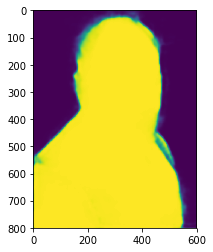

(800, 600)


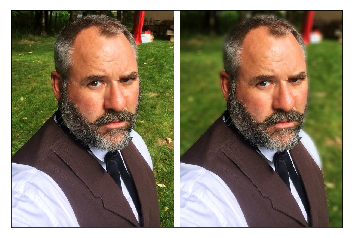

In [5]:
img_ori = cv2.imread("/home/anicca/Program/python/Data/EG1800/Images/00457.png")
# mask_ori = cv2.imread("/home/anicca/Program/python/Data/EG1800/Labels/00457.png")

prior = None
height, width, _ = img_ori.shape

background = img_ori.copy()
background = cv2.blur(background, (17,17))

alphargb, pred = pred_single(netmodel_video, exp_args, img_ori, prior)
plt.imshow(alphargb)
plt.show()
print alphargb.shape

alphargb = cv2.cvtColor(alphargb, cv2.COLOR_GRAY2BGR)
result = np.uint8(img_ori * alphargb + background * (1-alphargb))

myImg = np.ones((height, width*2 + 20, 3)) * 255
myImg[:, :width, :] = img_ori
myImg[:, width+20:, :] = result

plt.imshow(myImg[:,:,::-1]/255)
plt.yticks([])
plt.xticks([])
plt.show()

### video test

In [6]:
videofile = 'douyu_origin.mp4'
videoCapture = cv2.VideoCapture(videofile)  
size = ((int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH))+20)*3, int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))  
videoWriter = cv2.VideoWriter('result.mp4', cv2.VideoWriter_fourcc(*'MJPG'), 20, size)  

success, frame = videoCapture.read()
cnt = 1
while success:
    if cnt == 1:
        prior = None # first frame
    else:
        prior = pred_video
    
    alpha_video, pred_video = pred_single(netmodel_video, exp_args, frame, prior)
    alpha_image, pred_image = pred_single(netmodel_video, exp_args, frame, None)
    
    def blend(frame, alpha):
        background = np.zeros(frame.shape) + [255, 255, 255]
        alphargb = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)
        result = np.uint8(frame * alphargb + background * (1-alphargb))
        return frame, alphargb*255, result
    
    _, alphargb_video, _ = blend(frame, alpha_video)
    _, alphargb_image, _ = blend(frame, alpha_image)
    
    padding = np.ones((frame.shape[0], 20, 3), dtype = np.uint8)*255
    result = np.uint8(np.hstack((frame, padding,
                                 alphargb_video, padding,
                                 alphargb_image, padding)))
    videoWriter.write(result)
    success, frame = videoCapture.read()
    cnt += 1
    
    if cnt % 100 == 0:
        print ("cnt: ", cnt)
    
videoWriter.release()

print "finish"

('cnt: ', 100)
('cnt: ', 200)
('cnt: ', 300)
('cnt: ', 400)
('cnt: ', 500)
('cnt: ', 600)
finish
